In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
from tqdm import tqdm
import os
import PIL.Image as Image
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets
from torch.autograd import Variable

# Import and preprocess the data

In [2]:
train_transforms = transforms.Compose([ #data augmentation and normalization for the training set
    transforms.Resize((256)),
    transforms.RandomRotation(45),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([#normalisation of the data for the testing set                            
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
])


#downloading the datasets and define the loaders
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                        download=True, transform=train_transforms)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transforms)
val_loader = torch.utils.data.DataLoader(testset, batch_size=16,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

0it [00:00, ?it/s]

170500096it [00:06, 26295826.76it/s]                               


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Training the model from scratch (with pretrained optional)

In [0]:
pretrained = True #put it at false if you don't want a pretrained network
number_epoch = 20 #number of epochs

In [3]:
#importation of a pretrained resnet152 and change the last fully connected layer to adapt it for the classification
model = models.resnet152(pretrained=pretrained)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features,10)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth
100%|██████████| 230M/230M [00:01<00:00, 227MB/s]


2048


In [4]:
#We print the model we obtained
print(net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [0]:
#define an adaptative learning rate which will decrease with the number of epochs
def adjust_learning_rate(epoch):
    lr = 0.001

    if epoch > 100:
        return lr / 1000000
    elif epoch > 60:
        return lr / 100000
    elif epoch > 50:
        return lr / 10000
    elif epoch > 30:
        return lr / 1000
    elif epoch > 20:
        return lr / 100
    elif epoch > 10:
        return lr / 10
    return lr


In [7]:
#boolean to know if gpu is available
use_cuda = torch.cuda.is_available()


# Create experiment folder
if not os.path.isdir("best_models"):
    os.makedirs("best_models")

if use_cuda: #if gpu available, we move the model to gpu
    print('Using GPU')
    model.cuda()
    
else:
    print('Using CPU')

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) #We will use a SGD for optimizer

def train(epoch):  #the train for a single epoch
    model.train() 
    for batch_idx, (data, target) in enumerate(train_loader): #for each batch
        if use_cuda: #if cuda available, move the data and target to gpu
            data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)
        criterion = torch.nn.CrossEntropyLoss(reduction='mean') #We decide to use cross entropy loss for classification
        loss = criterion(output, target) #calculate the loss
        loss.backward() #do the backpropagation
        optimizer.step()
        if batch_idx % 50 == 0: #We print the results 
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

def validation(): #the evaluation of the test dataset
    model.eval()
    validation_loss = 0
    correct = 0
    for data, target in val_loader: #for each data target in the data loader
        if use_cuda: #if gpu is available, we move the data and target to gpu
            data, target = data.cuda(), target.cuda()
        output = model(data) 
        # sum up batch loss
        criterion = torch.nn.CrossEntropyLoss(reduction='mean') 
        validation_loss += criterion(output, target).data.item() #compute the loss
        # get the index of the max log-probability
        pred = output.data.max(1, keepdim=True)[1] #store the preduction
        correct += pred.eq(target.data.view_as(pred)).cpu().sum() #add +1 if the prediction is correct otherwise 0

    validation_loss /= len(val_loader.dataset) #calculate the loss
    #print the loss and the precision of the test set
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        validation_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))


lr = 0.001
for epoch in range(1, number_epoch + 1): #for each epoch
    optimizer = optim.SGD(model.parameters(), lr, momentum=0.9) #initialise the optimizer 
    train(epoch) #do the training of the epoch
    validation() #and the validation 
    model_file = 'best_models' + '/model_' + str(epoch) + '.pth' 
    torch.save(model.state_dict(), model_file) #save the weight of the model
    lr = adjust_learning_rate(epoch) #adjust the learning rate
    print('Saved model to ' + model_file )


Using GPU
Train Epoch: 1 [0/50000 (0%)]	Loss: 2.247956
Train Epoch: 1 [800/50000 (2%)]	Loss: 1.682932
Train Epoch: 1 [1600/50000 (3%)]	Loss: 1.428827
Train Epoch: 1 [2400/50000 (5%)]	Loss: 0.856192
Train Epoch: 1 [3200/50000 (6%)]	Loss: 0.375466
Train Epoch: 1 [4000/50000 (8%)]	Loss: 0.311743
Train Epoch: 1 [4800/50000 (10%)]	Loss: 0.517842
Train Epoch: 1 [5600/50000 (11%)]	Loss: 0.219456
Train Epoch: 1 [6400/50000 (13%)]	Loss: 0.377706
Train Epoch: 1 [7200/50000 (14%)]	Loss: 0.476246
Train Epoch: 1 [8000/50000 (16%)]	Loss: 1.186292
Train Epoch: 1 [8800/50000 (18%)]	Loss: 0.325166
Train Epoch: 1 [9600/50000 (19%)]	Loss: 0.481847
Train Epoch: 1 [10400/50000 (21%)]	Loss: 0.358318
Train Epoch: 1 [11200/50000 (22%)]	Loss: 0.303598
Train Epoch: 1 [12000/50000 (24%)]	Loss: 0.240508
Train Epoch: 1 [12800/50000 (26%)]	Loss: 0.582469
Train Epoch: 1 [13600/50000 (27%)]	Loss: 0.846305
Train Epoch: 1 [14400/50000 (29%)]	Loss: 0.623094
Train Epoch: 1 [15200/50000 (30%)]	Loss: 0.388029
Train Epoch: 

KeyboardInterrupt: ignored

# Or load the weight I have saved

In [0]:
weight_path = "/content/best_models/model_11.pth" #put the pass of the weight

In [12]:
model = models.resnet152(pretrained=False)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features,10)

state_dict = torch.load(weight_path)
model.load_state_dict(state_dict)
model.eval()

if use_cuda:
    print('Using GPU')
    model.cuda()
else:
    print('Using CPU')
        


Using GPU


# Quantitative results ( accuracy )

In [13]:
validation() 


Validation set: Average loss: 0.0057, Accuracy: 9727/10000 (97%)


# Qualitative results

In [0]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    img = img.cpu()
    npimg = img.numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


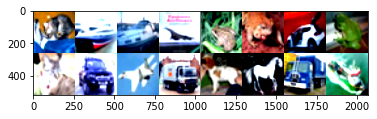

GroundTruth:    cat  ship  ship plane  frog  frog   car  frog   cat   car plane truck   dog horse truck  ship
Predicted:    cat  ship  ship plane  frog  frog   car  frog   cat   car plane truck   dog horse truck  ship


In [54]:
val_loader = torch.utils.data.DataLoader(testset, batch_size=16,
                                         shuffle=False, num_workers=2)

dataiter = iter(val_loader)
images, labels = dataiter.next()
if use_cuda:
  images, labels = images.cuda(), labels.cuda()
imshow(torchvision.utils.make_grid(images)) #We show images from test dataset
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(16))) #avec leurs vrai labels

#et on affiche nos predictions
outputs = model(images)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(16)))
